# Section one: Getting refined coordinates:

In [84]:
# numpy
import numpy as np
from numpy import unravel_index
print( 'Using numpy version %s' % np.__version__ )

# matplotlib and inline display in notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
print( 'Using matplotlib version %s' % mpl.__version__ )

# matplotlib toolkits
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes



import photutils

from astropy.io import fits

from astropy.wcs import WCS
import astropy.units as u
from astropy.coordinates import SkyCoord

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from photutils.aperture import SkyCircularAperture, SkyCircularAnnulus, aperture_photometry
# scipy
import scipy as scp
from scipy.ndimage import label
from scipy.interpolate import interp1d
from scipy.stats import sigmaclip, iqr
print( 'Using scipy version %s' % scp.__version__ )

# system
import glob, os

# astropy
import astropy as astro
from astropy.table import Table
from astropy.io import ascii, fits
from astropy.stats import sigma_clip
import astropy.units as u
from astropy.cosmology import Planck15
from astropy.convolution import convolve_fft, Box2DKernel
from astropy.coordinates import SkyCoord
from astropy.nddata.utils import Cutout2D
from astropy.wcs import WCS
print( 'Using astropy version %s' % astro.__version__ )

# photutils
import photutils as phot
from photutils import EllipticalAperture, EllipticalAnnulus, aperture_photometry, CircularAnnulus, CircularAperture, SkyEllipticalAnnulus, SkyEllipticalAperture, SkyCircularAperture, SkyCircularAnnulus
from photutils.detection import DAOStarFinder
print( 'Using photutils version %s' % phot.__version__ )

# text below modifies matplotlib settings so LaTeX can be used in plots
params = {'text.usetex': False, 'mathtext.fontset': 'stixsans'}
plt.rcParams.update(params)



Using numpy version 1.25.2
Using matplotlib version 3.6.0
Using scipy version 1.11.3
Using astropy version 6.0.1
Using photutils version 1.12.0


/var/folders/by/26kj85kd3w94p3xv_m2206b40000gn/T/ipykernel_20882/1483311193.py:58: DeprecationWarning: `photutils.EllipticalAperture` is a deprecated alias for `photutils.aperture.EllipticalAperture` and will be removed in the future. Instead, please use `from photutils.aperture import EllipticalAperture` to silence this warning.
  from photutils import EllipticalAperture, EllipticalAnnulus, aperture_photometry, CircularAnnulus, CircularAperture, SkyEllipticalAnnulus, SkyEllipticalAperture, SkyCircularAperture, SkyCircularAnnulus
/var/folders/by/26kj85kd3w94p3xv_m2206b40000gn/T/ipykernel_20882/1483311193.py:58: DeprecationWarning: `photutils.EllipticalAnnulus` is a deprecated alias for `photutils.aperture.EllipticalAnnulus` and will be removed in the future. Instead, please use `from photutils.aperture import EllipticalAnnulus` to silence this warning.
  from photutils import EllipticalAperture, EllipticalAnnulus, aperture_photometry, CircularAnnulus, CircularAperture, SkyEllipticalAnn

In [85]:
# Load the catalog
clump_catalog_path = '/Users/neal/Documents/PhD/projects/SED-fitting/Clump/results/catalog_n/goodsslast.csv'
clump_catalog = pd.read_csv(clump_catalog_path)

### 1) Load images and select bandpass:

In [86]:
def load_image(galaxy_id, band, base_path='/Users/neal/Documents/PhD/projects/SED-fitting/Clump/Cutouts_galaxies'):
    file_name = f'{base_path}/goodss_{galaxy_id}_{band}_images.fits'
    with fits.open(file_name) as hdul:
        image_data = hdul[0].data
        wcs = WCS(hdul[0].header)  # Extract the WCS information from the header
    return image_data, wcs

def get_band_from_redshift(z):
    if 0.5 <= z < 1:
        return 'f275w'
    elif 1 <= z < 2:
        return 'f435w'
    elif 2 <= z <= 3:
        return 'f606w'
    else:
        raise ValueError("Redshift out of bounds for band selection")

### 2) aperture and mask:

In [87]:
def apply_mask(image_data, wcs, ra_clump, dec_clump):
    target_coords = SkyCoord(ra=ra_clump, dec=dec_clump, unit='deg')
    target_aperture = SkyCircularAperture(target_coords, r=0.18 * u.arcsec).to_pixel(wcs)
    mask = target_aperture.to_mask(method='center')
    masked_image = mask.to_image(image_data.shape)

    # Enhance image by subtracting the smoothed image
    smooth_kernel = Box2DKernel(width=10)
    smooth_img = convolve_fft(image_data, smooth_kernel)
    contrast_img = image_data - smooth_img

    # Finding sources using DAOStarFinder
    daofind = DAOStarFinder(fwhm=2.0, threshold=3*np.median(masked_image * image_data))
    sources = daofind(masked_image * image_data)
    if sources is not None and len(sources) > 0:
        idx = np.argmax(sources['peak'])
        return sources['xcentroid'][idx], sources['ycentroid'][idx] #,masked_image, contrast_img
    return None, None #masked_image, contrast_img### added last two

### 4)process each clump

In [88]:
# Process each clump in the catalog
base_path = '/Users/neal/Documents/PhD/projects/SED-fitting/Clump/Cutouts_galaxies'
def process_clumps(dataframe, base_path):
    for index, row in dataframe.iterrows():
        if row['Clump_ID'] != -99:
            band = get_band_from_redshift(row['z'])
            image_data, wcs = load_image(row['CANDELS_ID'], band, base_path)
            x_new, y_new = apply_mask(image_data, wcs, row['RA_clump'], row['DEC_clump'])

            if x_new is not None and y_new is not None:
                dataframe.at[index, 'new_X_centroid'] = x_new
                dataframe.at[index, 'new_Y_centroid'] = y_new
                # print(f"Updated clump {row['Clump_ID']} at index {index} with new center: ({x_new}, {y_new})")
            else:
                print(f"No sources found for clump {row['Clump_ID']} at index {index}")
    return dataframe

In [89]:
goodss_result = process_clumps(clump_catalog, base_path)
goodss_result.to_csv('/Users/neal/Documents/PhD/projects/SED-fitting/Clump/results/newcenters_goodsslast.csv', index=False)


/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/pyth

No sources found for clump 3 at index 275


/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/pyth

No sources found for clump 1 at index 792


/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/pyth

No sources found for clump 3 at index 922
No sources found for clump 1 at index 928


/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/pyth

No sources found for clump 4 at index 1157


/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/pyth

No sources found for clump 1 at index 1202


/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/pyth

No sources found for clump 3 at index 1230


/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/pyth

No sources found for clump 1 at index 1449


/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/pyth

No sources found for clump 1 at index 1479


/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/pyth

No sources found for clump 1 at index 2056


/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/pyth

No sources found for clump 2 at index 2234
No sources found for clump 3 at index 2235


/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/pyth

No sources found for clump 1 at index 2311


/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/pyth

No sources found for clump 1 at index 2363


/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/pyth

No sources found for clump 11 at index 2392


/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/pyth

No sources found for clump 5 at index 2460


/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/pyth

No sources found for clump 2 at index 2603


/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/pyth

No sources found for clump 1 at index 2709


/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/pyth

No sources found for clump 5 at index 2822


/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/pyth

No sources found for clump 2 at index 2865


/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/pyth

No sources found for clump 7 at index 3007


/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/pyth

No sources found for clump 1 at index 3027


/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/pyth

No sources found for clump 2 at index 3050
No sources found for clump 3 at index 3064


/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/pyth

No sources found for clump 7 at index 3540


/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/pyth

No sources found for clump 2 at index 3721


/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)
/Users/neal/anaconda3/lib/pyth

# Run it on first 20 clumps:

In [90]:
def process_clumps(dataframe, base_path):
    for index, row in dataframe.iterrows():
        if index >= 20:
            break  # Process only the first 20 entries
        if row['Clump_ID'] != -99:
            band = get_band_from_redshift(row['z'])
            image_data, wcs = load_image(row['CANDELS_ID'], band, base_path)
            target_coords = SkyCoord(row['RA_clump'], row['DEC_clump'], unit='deg')
            target_aperture = SkyCircularAperture(target_coords, r=0.18 * u.arcsec).to_pixel(wcs)
            
            # Apply mask and visualize
            mask = target_aperture.to_mask(method='center')
            masked_image = mask.to_image(image_data.shape)
            # masked_image= mask.multiply(image_data)

            # Enhance image for detection
            smooth_kernel = Box2DKernel(width=10)
            smooth_img = convolve_fft(image_data, smooth_kernel)
            contrast_img = image_data - smooth_img
            daofind = DAOStarFinder(fwhm=2.0, threshold=3*np.median(masked_image * image_data))
            sources = daofind(masked_image * image_data)

# Visualize the original image with aperture overlay
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.imshow(image_data, origin='lower')
            target_aperture.plot(color='red', lw=1.5)
            plt.colorbar()
            plt.title("Original Image with Aperture")

            # Apply mask and visualize
            
            plt.subplot(1, 2, 2)
            plt.imshow(masked_image * image_data ,origin='lower')
            plt.colorbar()
            plt.title("Masked Image")
            plt.show()

            # Visualize detections in contrast image
            plt.figure(figsize=(10, 5))
            plt.imshow(masked_image * contrast_img, origin='lower')
            plt.colorbar()
            plt.title("Contrast Image with Detections")
            if sources is not None:
                max_peak_idx = np.argmax(sources['peak'])
                plt.scatter(sources['xcentroid'][max_peak_idx], sources['ycentroid'][max_peak_idx], color='red', s=10, edgecolor='white', label='Brightest Source')
                plt.legend()
            plt.show()
            # Update the DataFrame with new centroid coordinates, if sources detected
            if sources is not None and len(sources) > 0:
                idx_max = np.argmax(sources['peak'])
                dataframe.at[index, 'new_X_centroid'] = sources['xcentroid'][idx_max]
                dataframe.at[index, 'new_Y_centroid'] = sources['ycentroid'][idx_max]
                # print(f"Updated clump {row['Clump_ID']} at index {index} with new center: ({sources['xcentroid'][idx_max]}, {sources['ycentroid'][idx_max]})")
            else:
                print(f"No sources found for clump {row['Clump_ID']} at index {index}")

    return dataframe
    return dataframe


/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)


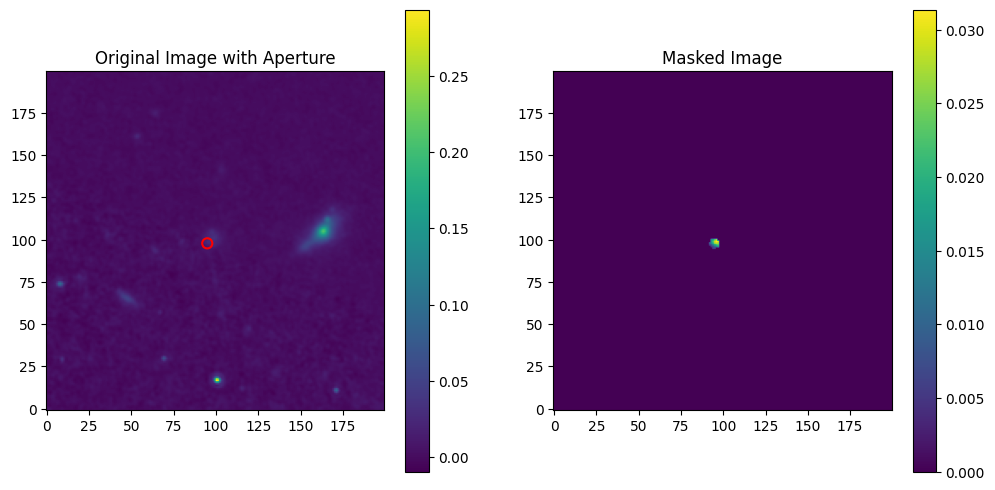

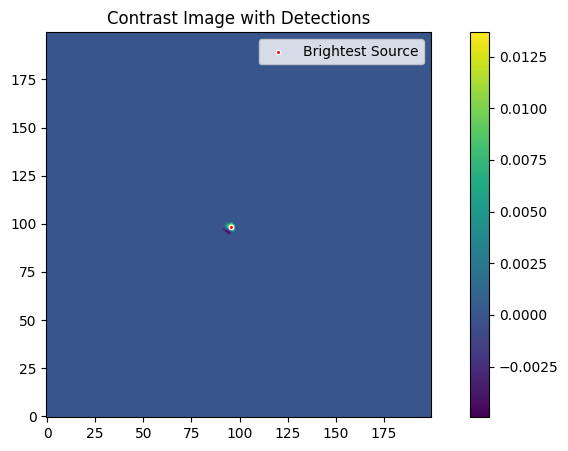

/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)


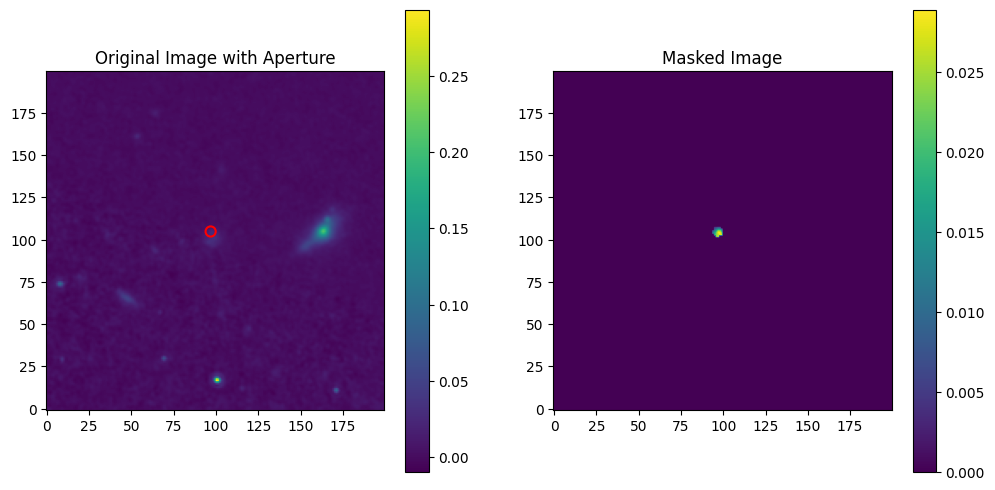

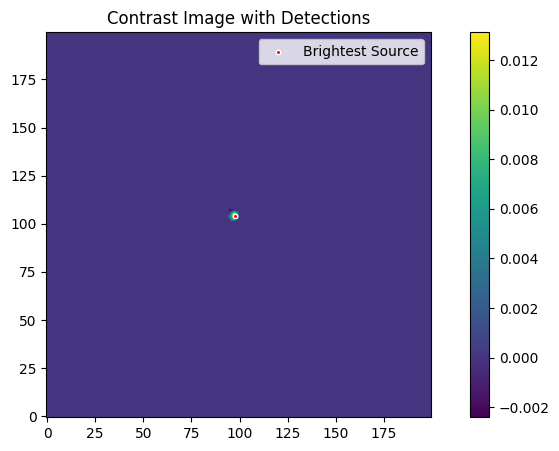

/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)


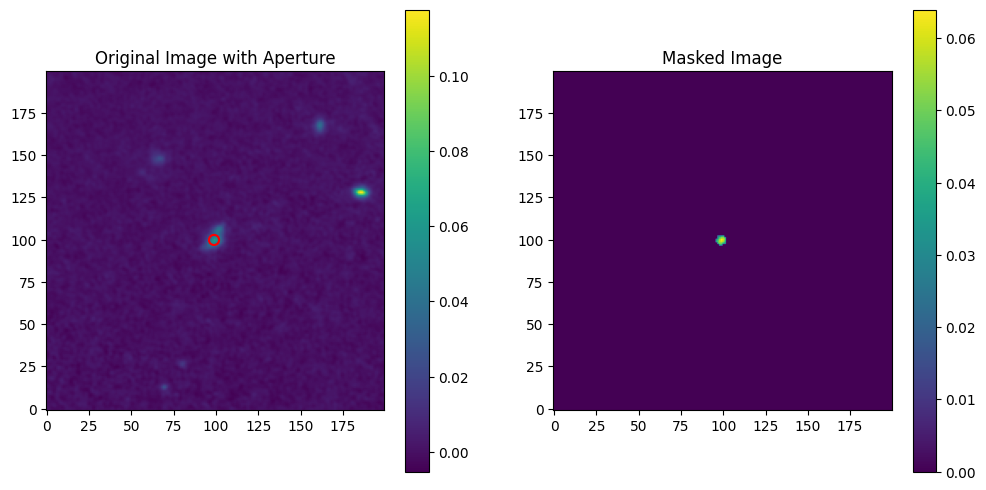

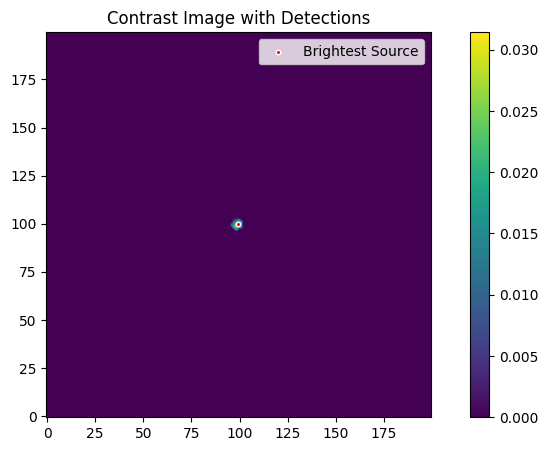

/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)


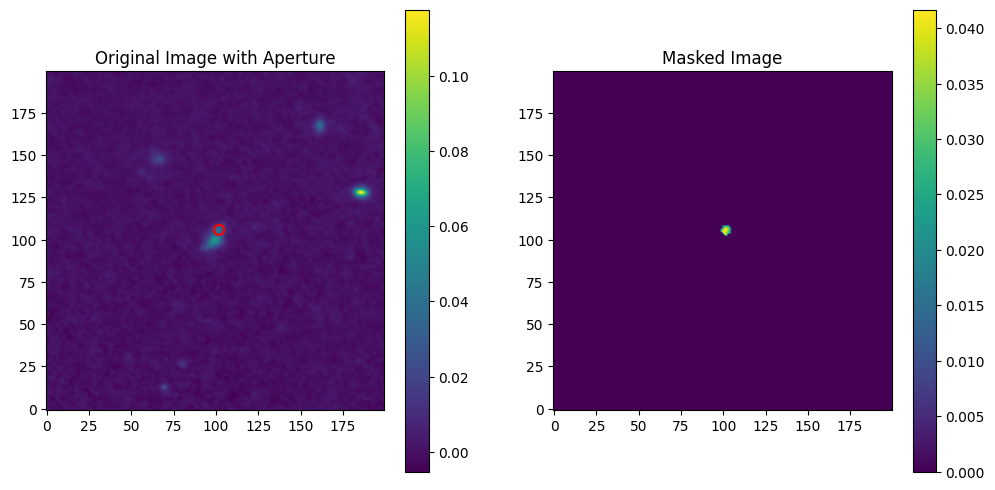

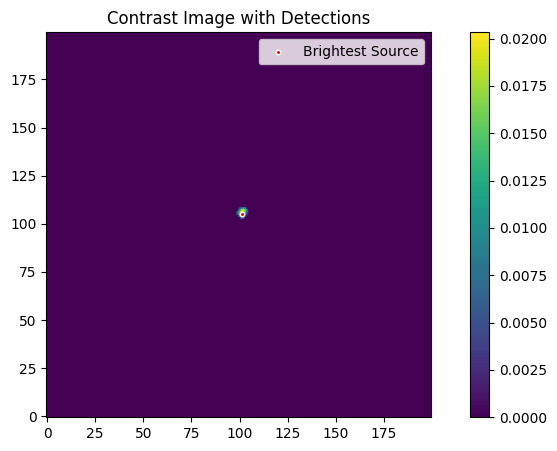

/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)


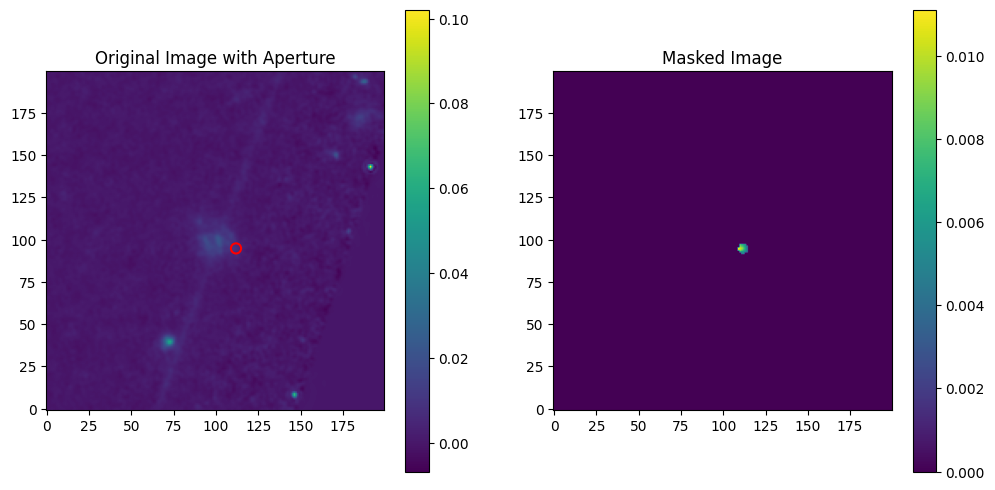

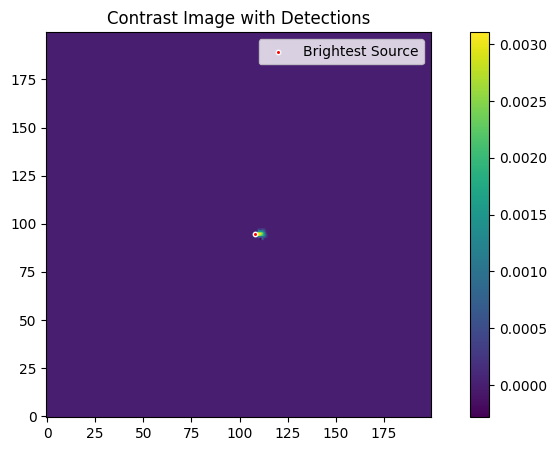

/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)


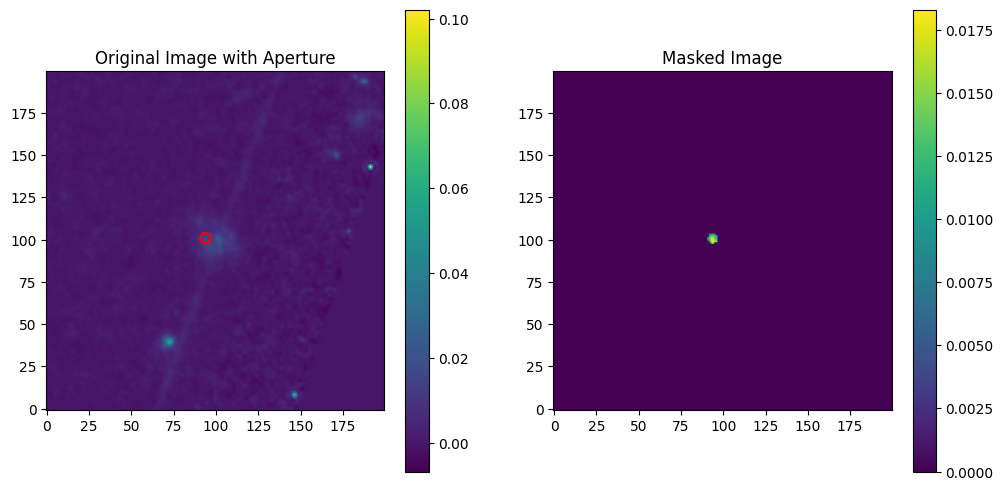

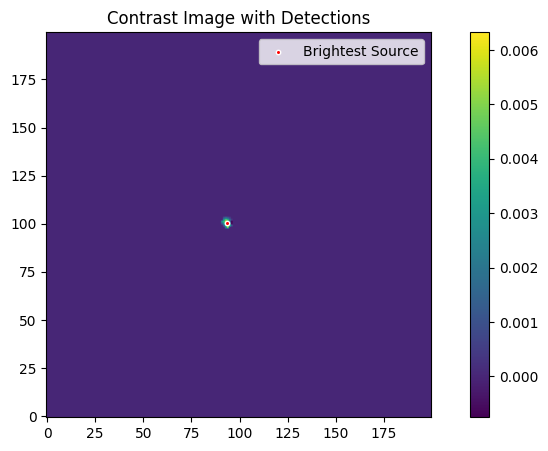

/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)


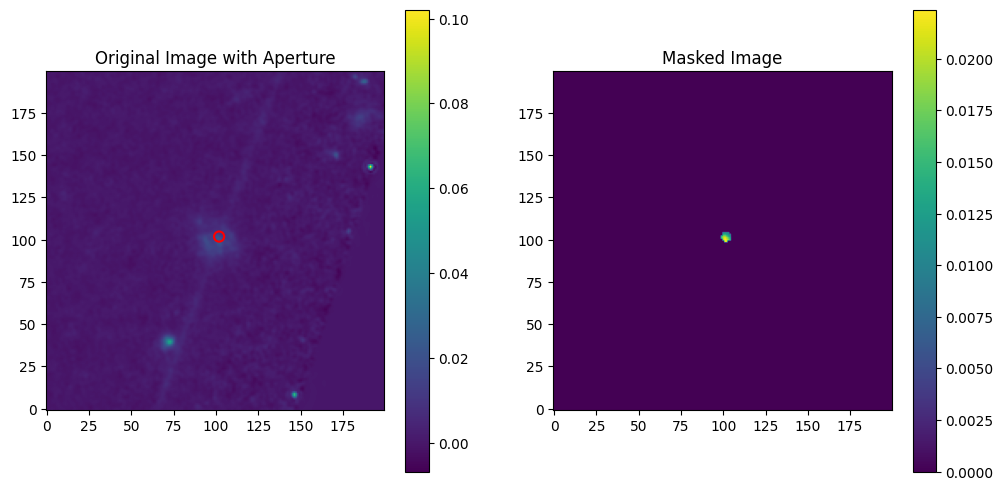

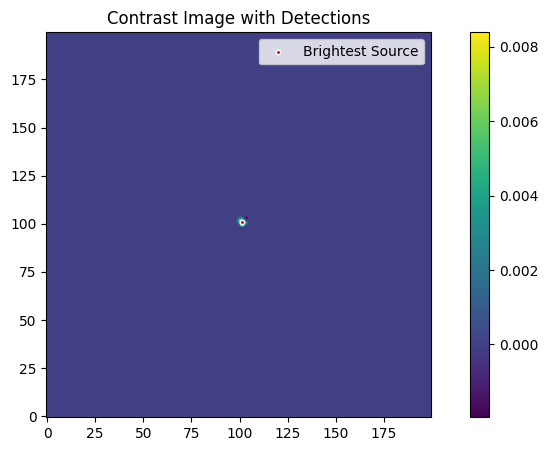

/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)


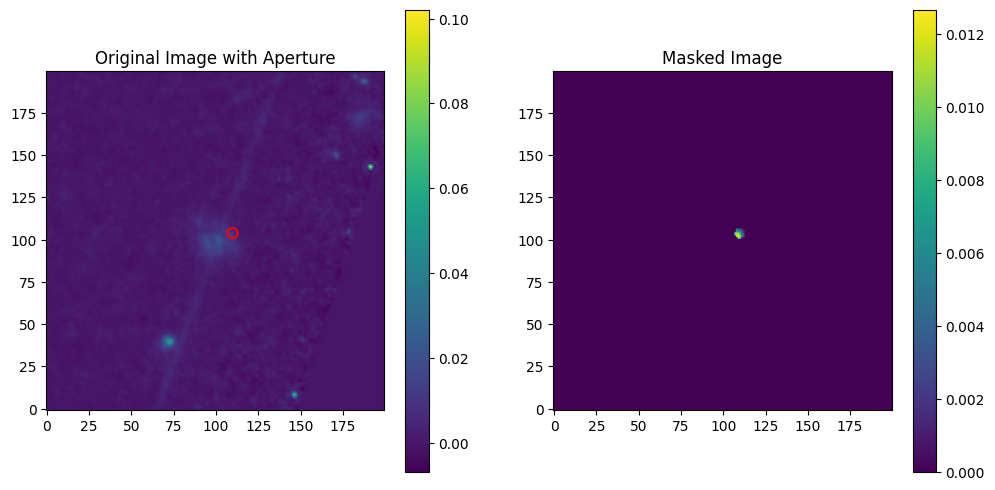

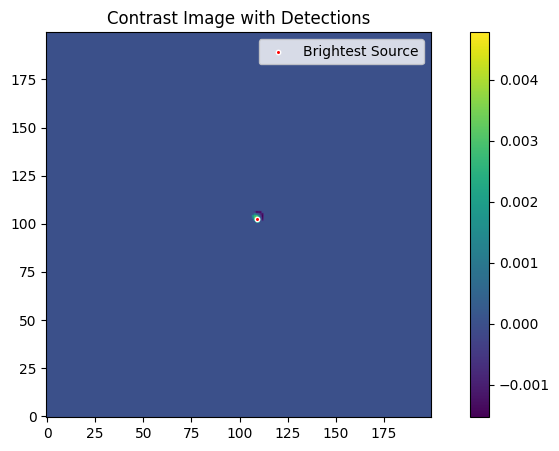

/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)


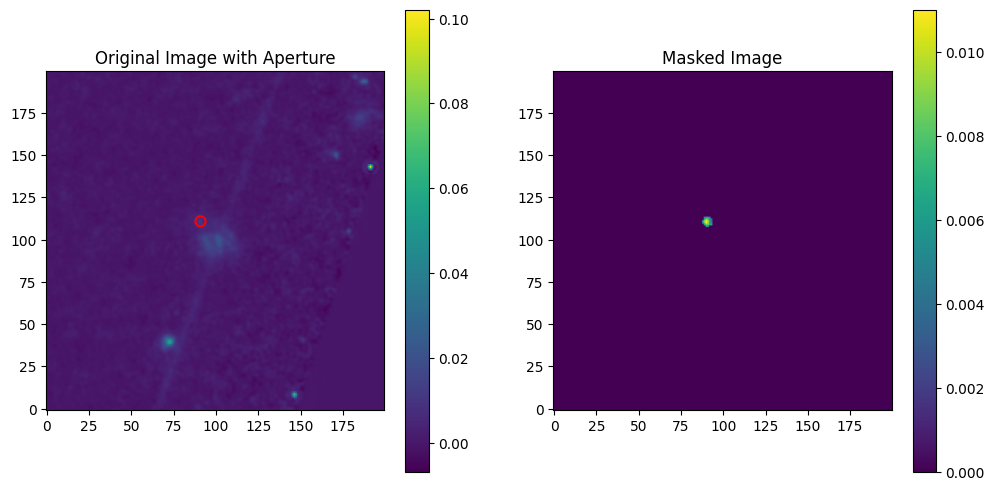

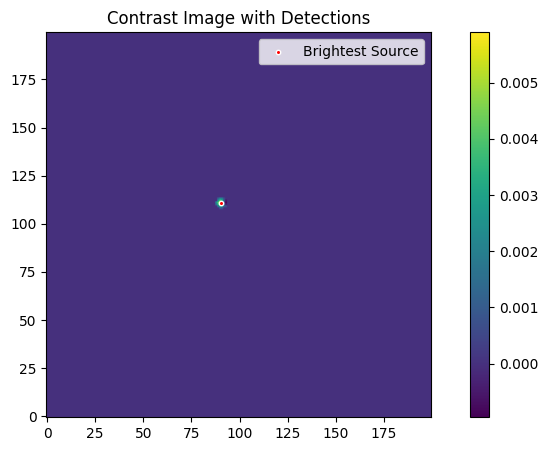

/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)


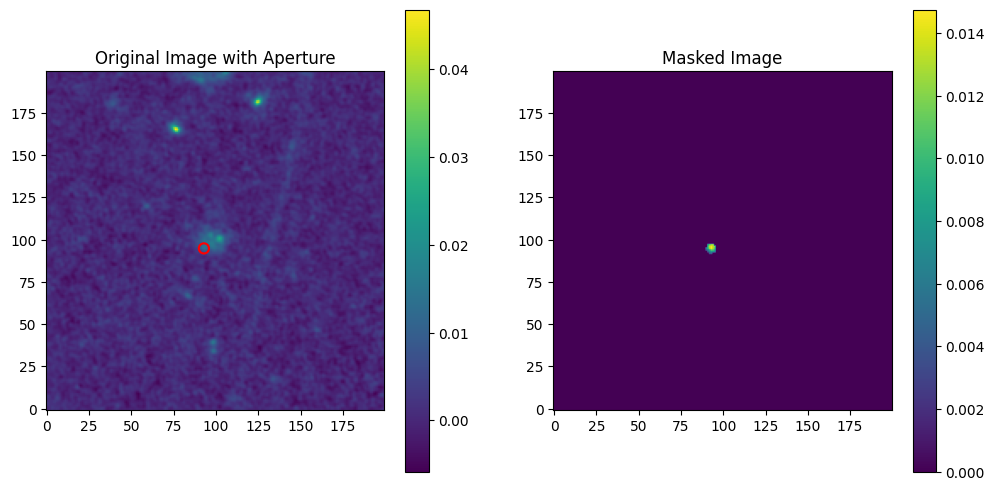

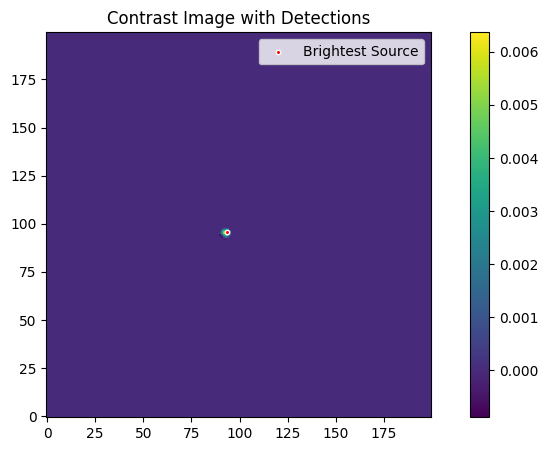

/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)


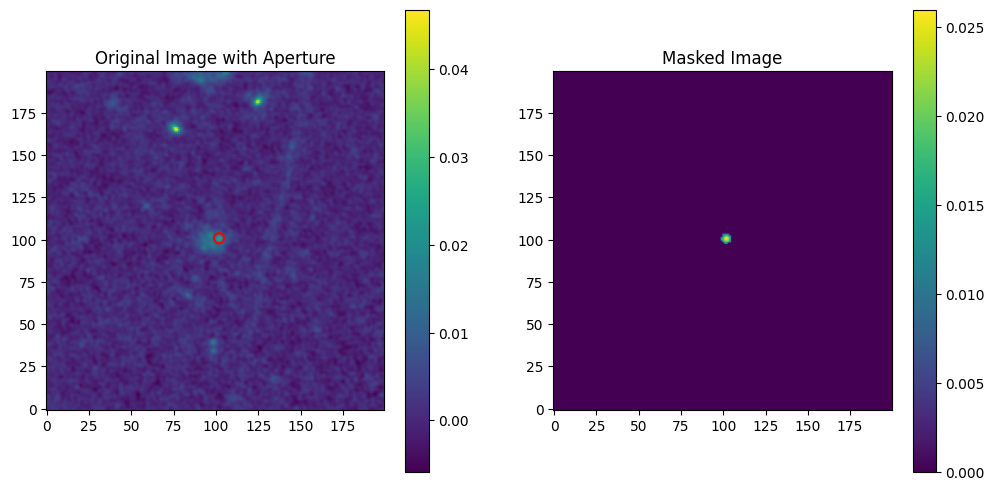

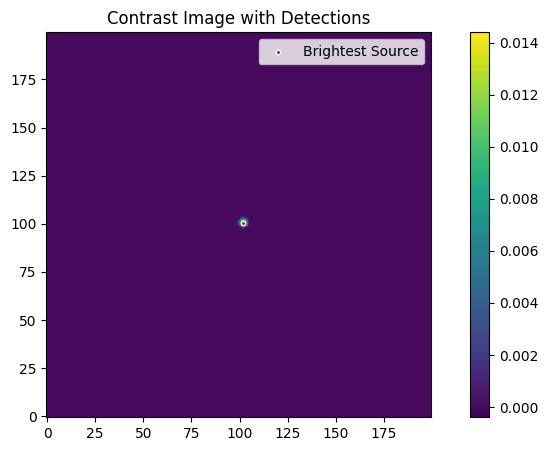

/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)


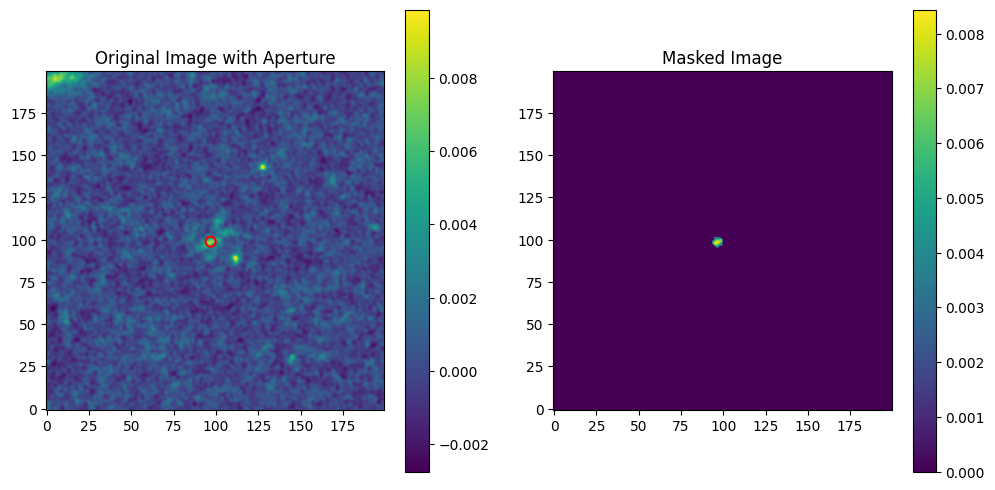

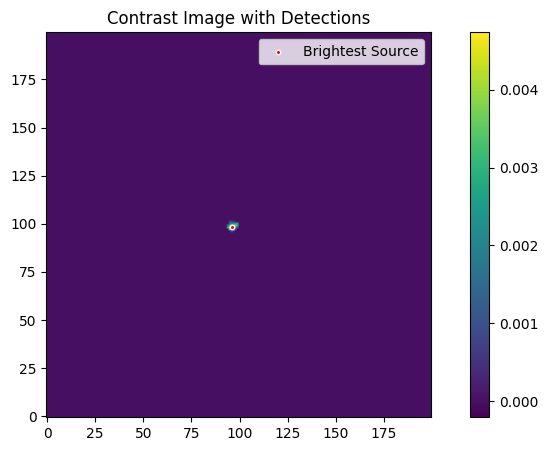

/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)


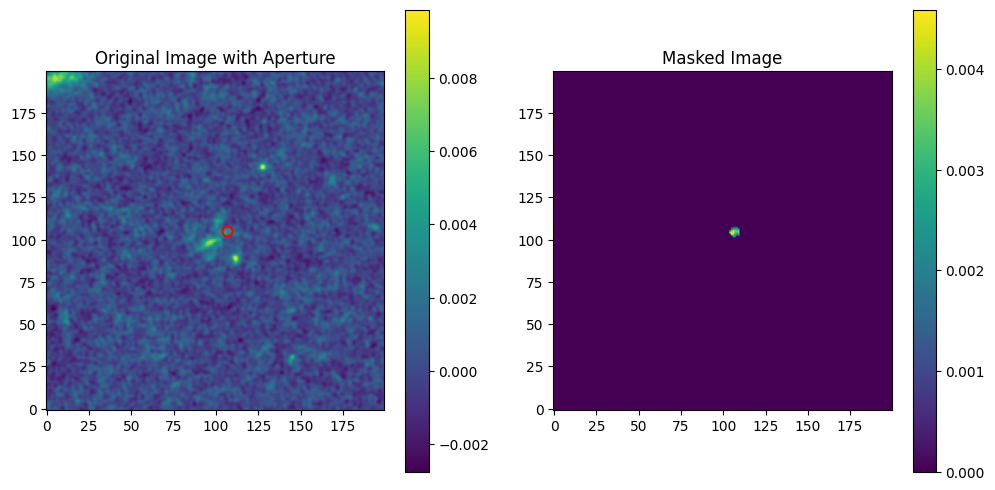

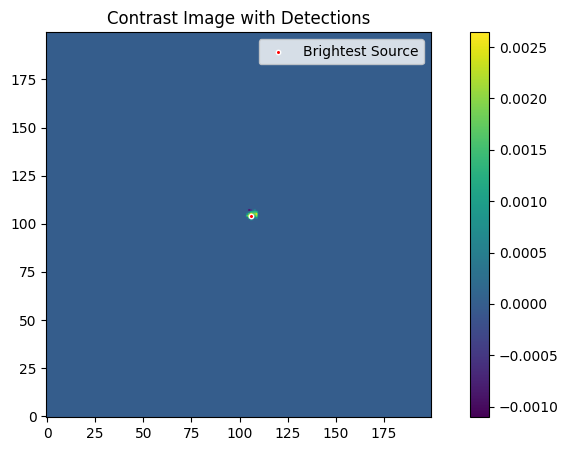

/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)


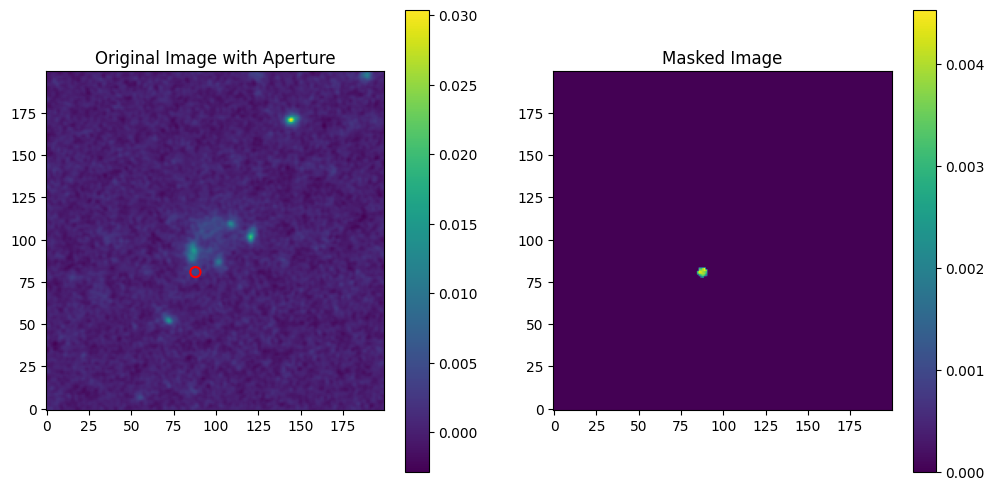

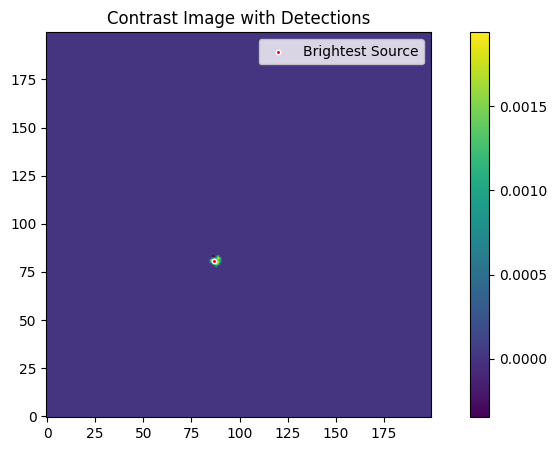

/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)


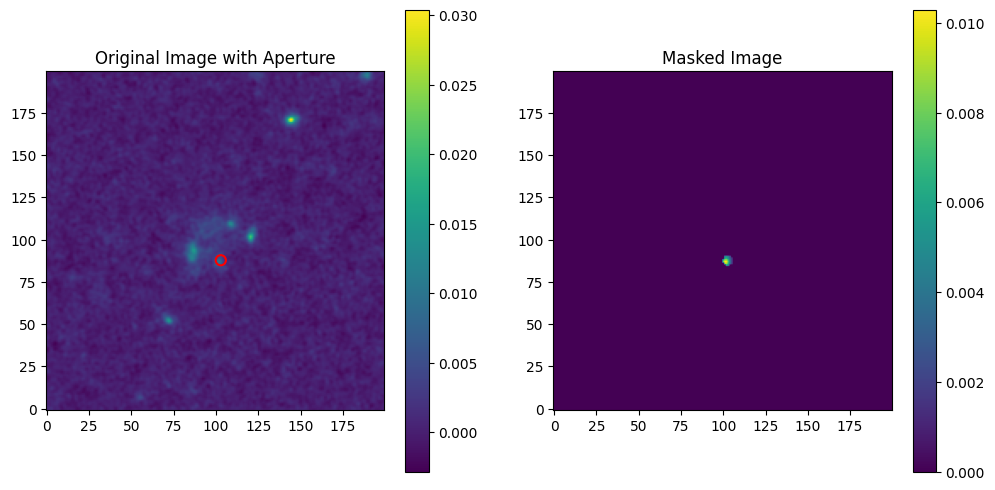

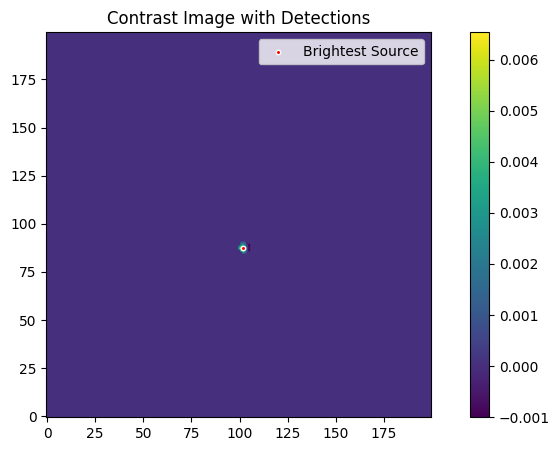

/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)


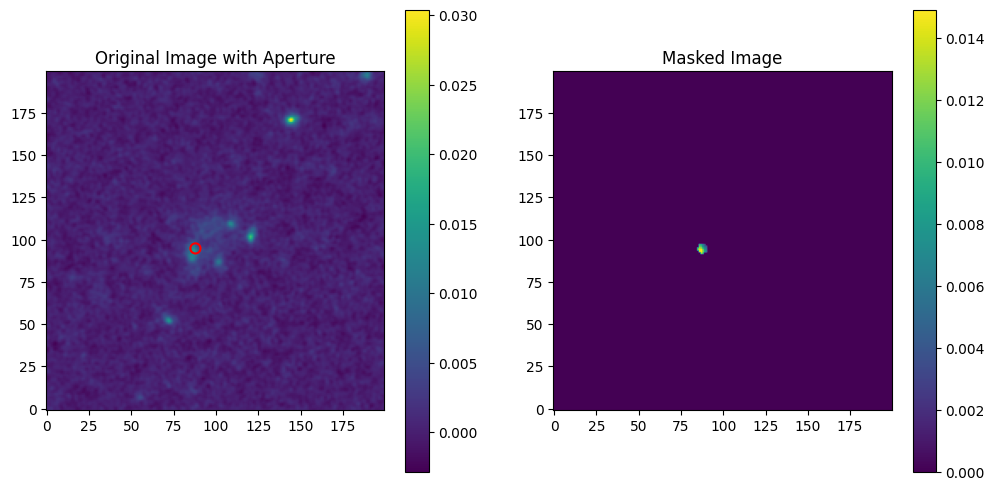

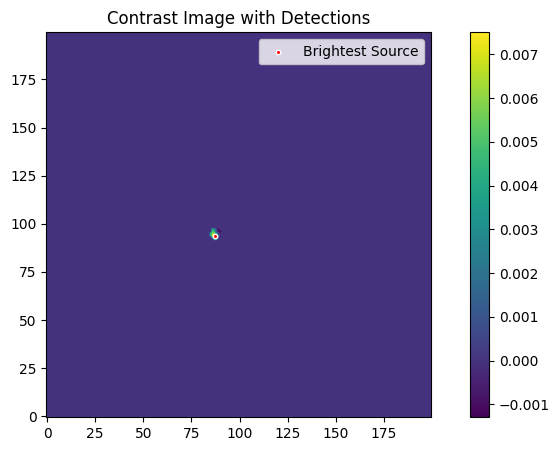

/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)


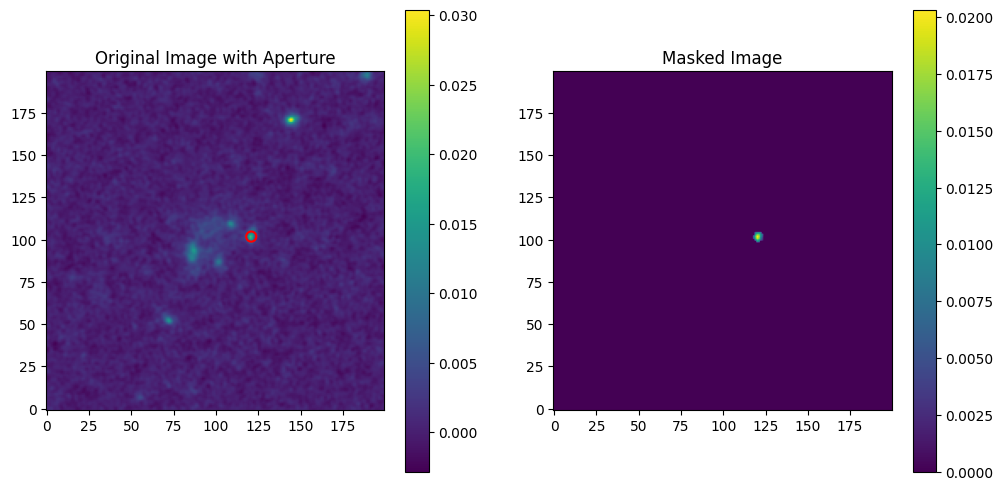

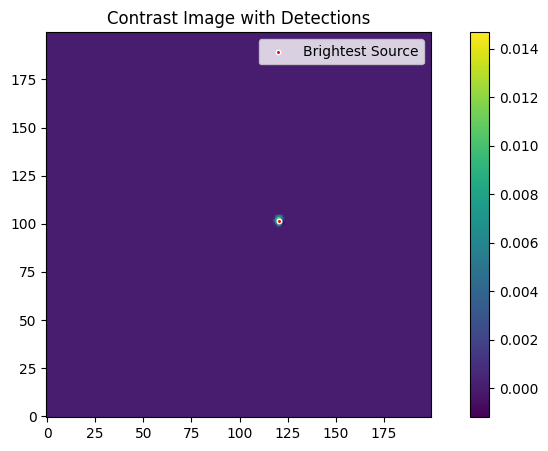

/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)


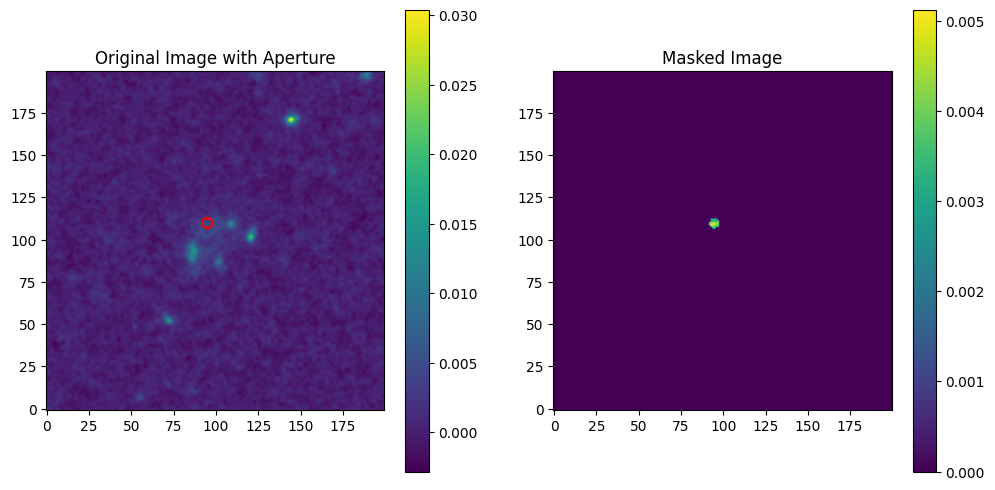

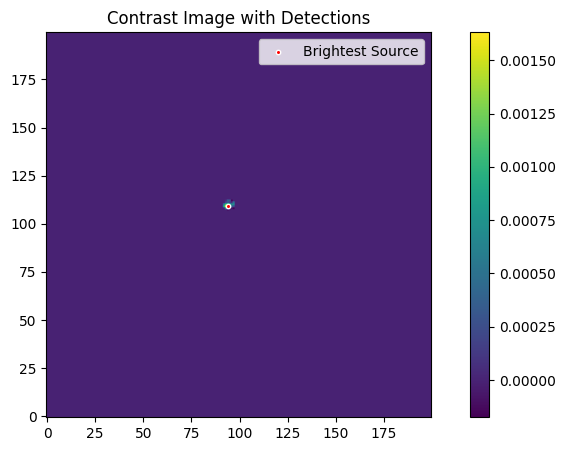

/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)


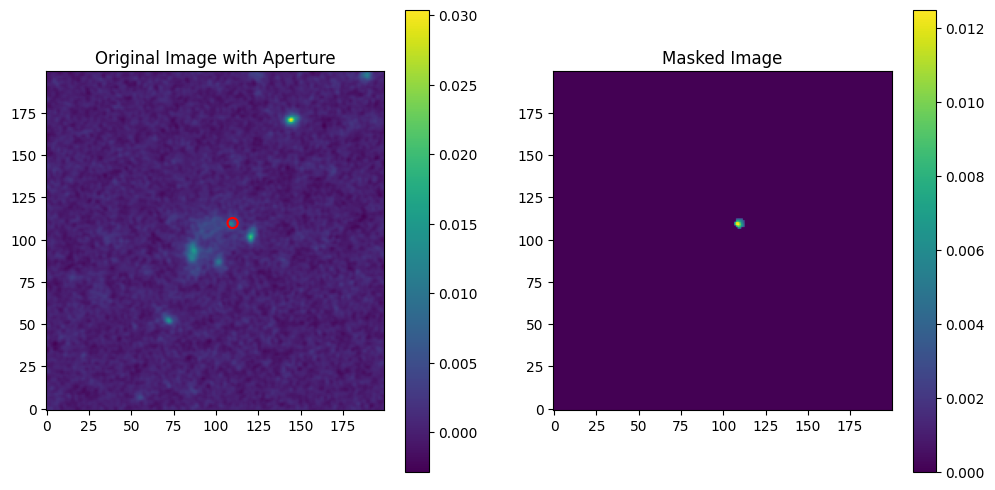

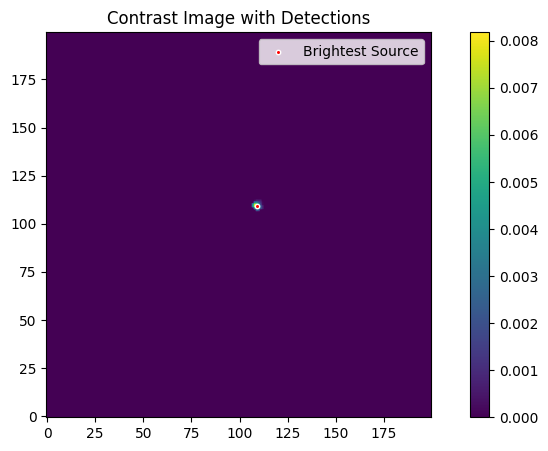

/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)


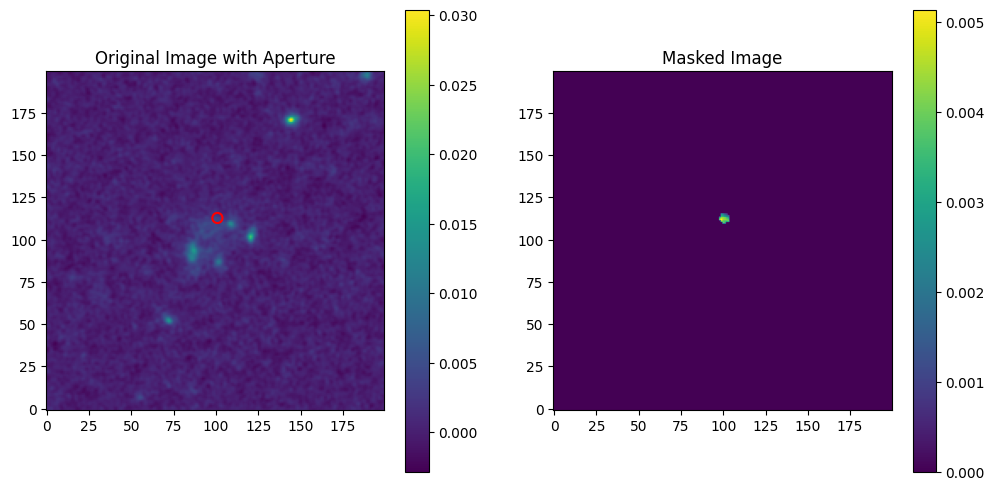

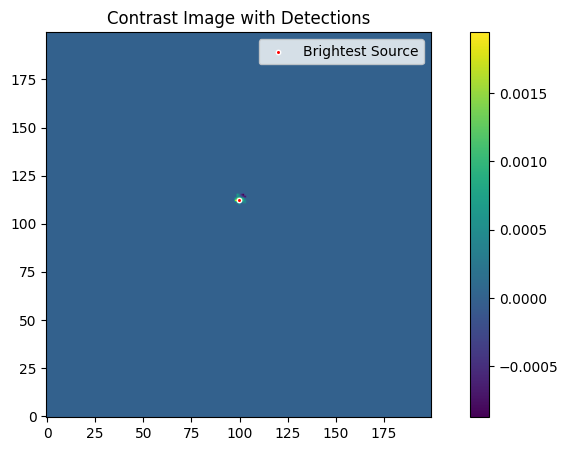

Unnamed: 0   Field  CANDELS_ID      z     RA_gal    DEC_gal      A  \
0              0  goodss          18  2.658  53.103527 -27.956482  4.078   
1              1  goodss          18  2.658  53.103527 -27.956482  4.078   
2              2  goodss          31  2.667  53.103826 -27.954019  3.839   
3              3  goodss          31  2.667  53.103826 -27.954019  3.839   
4              4  goodss          40  1.056  53.088263 -27.954256  7.522   
...          ...     ...         ...    ...        ...        ...    ...   
4058        4058  goodss       26763  2.408  53.135199 -27.705983  5.185   
4059        4059  goodss       26783  2.615  53.150381 -27.706844  6.065   
4060        4060  goodss       26783  2.615  53.150381 -27.706844  6.065   
4061        4061  goodss       26783  2.615  53.150381 -27.706844  6.065   
4062        4062  goodss       26788  1.524  53.099518 -27.706161  5.552   

      Clump_ID  dist_clump  flux_ratio  restuv_flux   RA_clump  DEC_clump  \
0            1    4.361886    0.223942     0.333196  53.103609 -27.956512   
1            2    6.206130    0.120983     0.333196  53.103571 -27.956396   
2            1    0.720425    0.406089     0.539943  53.103836 -27.954012   
3            2    6.838422    0.100441     0.539943  53.103779 -27.953912   
4            1   13.107481    0.010098     1.373450  53.088024 -27.954326   
...        ...         ...         ...          ...        ...        ...   
4058       -99  -99.000000  -99.000000   -99.000000 -99.000000 -99.000000   
4059         1    7.704078    0.052889     0.742023  53.150339 -27.706978   
4060         2    1.644023    0.161235     0.742023  53.150415 -27.706878   
4061         3    6.935619    0.166425     0.742023  53.150415 -27.706745   
4062       -99  -99.000000  -99.000000   -99.000000 -99.000000 -99.000000   

      new_X_centroid  new_Y_centroid  
0          95.725251       98.596811  
1          97.492705      103.899455  
2          99.433067      100.094554  
3         101.265618      105.098161  
4         108.208208       94.481458  
...              ...             ...  
4058             NaN             NaN  
4059      101.313517       92.890892  
4060       98.706059       98.692619  
4061       98.438529      105.192628  
4062             NaN             NaN  

[4063 rows x 15 columns]

In [91]:
process_clumps(clump_catalog,base_path)

# Sectioon 2: Photometry on the new X and Y:

### 1)converting New x and y to RA/DEC: